In [1]:

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import unicodedata
import pandas as pd

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import json
# import acquire

from env import github_token, github_username
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords



In [2]:
df = pd.read_json('data2.json')

In [3]:
df.shape

(250, 3)

In [4]:
df.head()

,repo,language,readme_contents
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...
1,bitcoinbook/bitcoinbook,AsciiDoc,Code Examples: ![travis_ci](https://travis-ci....
2,bitcoinj/bitcoinj,Java,image:https://github.com/bitcoinj/bitcoinj/wor...
3,bitcoin/bips,Wikitext,"People wishing to submit BIPs, first should pr..."
4,bitcoinjs/bitcoinjs-lib,TypeScript,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...


In [5]:
for i, row in df.iterrows():
    if str(row['language']) in ['python', 'JavaScript', 'C++']:
        continue
    else:
        df.iloc[i]['language'] = 'other'

In [6]:
def clean_text(text):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english')
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', ' ', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:

df['clean'] = df['readme_contents'].apply(clean_text)

In [8]:
df.head()

,repo,language,readme_contents,clean
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,"[bitcoin, core, integration, staging, tree, ht..."
1,bitcoinbook/bitcoinbook,other,Code Examples: ![travis_ci](https://travis-ci....,"[code, example, travis_ci, http, travis, ci, o..."
2,bitcoinj/bitcoinj,other,image:https://github.com/bitcoinj/bitcoinj/wor...,"[image, http, github, com, bitcoinj, bitcoinj,..."
3,bitcoin/bips,other,"People wishing to submit BIPs, first should pr...","[people, wishing, submit, bips, first, propose..."
4,bitcoinjs/bitcoinjs-lib,other,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...,"[bitcoinjs, bitcoinjs, lib, github, ci, http, ..."


In [9]:
df.language.unique()

array(['C++', 'other', 'JavaScript'], dtype=object)

In [10]:
words = clean_text(' '.join(df['readme_contents']))


In [11]:
words

['bitcoin',
 'core',
 'integration',
 'staging',
 'tree',
 'http',
 'bitcoincore',
 'org',
 'immediately',
 'usable',
 'binary',
 'version',
 'bitcoin',
 'core',
 'software',
 'see',
 'http',
 'bitcoincore',
 'org',
 'en',
 'download',
 'bitcoin',
 'core',
 'bitcoin',
 'core',
 'connects',
 'bitcoin',
 'peer',
 'peer',
 'network',
 'download',
 'fully',
 'validate',
 'block',
 'transaction',
 'also',
 'includes',
 'wallet',
 'graphical',
 'user',
 'interface',
 'optionally',
 'built',
 'information',
 'bitcoin',
 'core',
 'available',
 'doc',
 'folder',
 'doc',
 'license',
 'bitcoin',
 'core',
 'released',
 'term',
 'mit',
 'license',
 'see',
 'copying',
 'copying',
 'information',
 'see',
 'http',
 'opensource',
 'org',
 'license',
 'mit',
 'development',
 'process',
 'master',
 'branch',
 'regularly',
 'built',
 'see',
 'doc',
 'build',
 'md',
 'instruction',
 'tested',
 'guaranteed',
 'completely',
 'stable',
 'tag',
 'http',
 'github',
 'com',
 'bitcoin',
 'bitcoin',
 'tag',
 'crea

In [12]:
def get_ngram(topic, n=1):
    if n ==1: 
        unigrams = pd.Series(nltk.ngrams(topic, 1))
        return unigrams
    elif n==2 :
        bigrams = pd.Series(nltk.ngrams(topic, 2))
        return bigrams
    elif n ==3 :
        trigrams = pd.Series(nltk.ngrams(topic, 3))
        return trigrams
    else: 
        return None

#### 1. What are the most common words in READMEs?

In [13]:
words_unigrams = get_ngram(words)
words_unigrams

0                      (bitcoin,)
1                         (core,)
2                  (integration,)
3                      (staging,)
4                         (tree,)
                   ...           
150792               (assert_eq,)
150793                  (master,)
150794               (encrypted,)
150795    (reconstructed_master,)
150796               (encrypted,)
Length: 150797, dtype: object

In [14]:
top_20_words_unigrams = words_unigrams.value_counts().head(20)
top_20_words_unigrams

(http,)           4929
(bitcoin,)        2980
(com,)            2911
(github,)         1616
(0,)               948
(wallet,)          884
(1,)               880
(transaction,)     830
(io,)              814
(org,)             746
(key,)             738
(use,)             658
(api,)             647
(run,)             616
(www,)             601
(build,)           576
(block,)           546
(2,)               533
(address,)         532
(file,)            517
dtype: int64

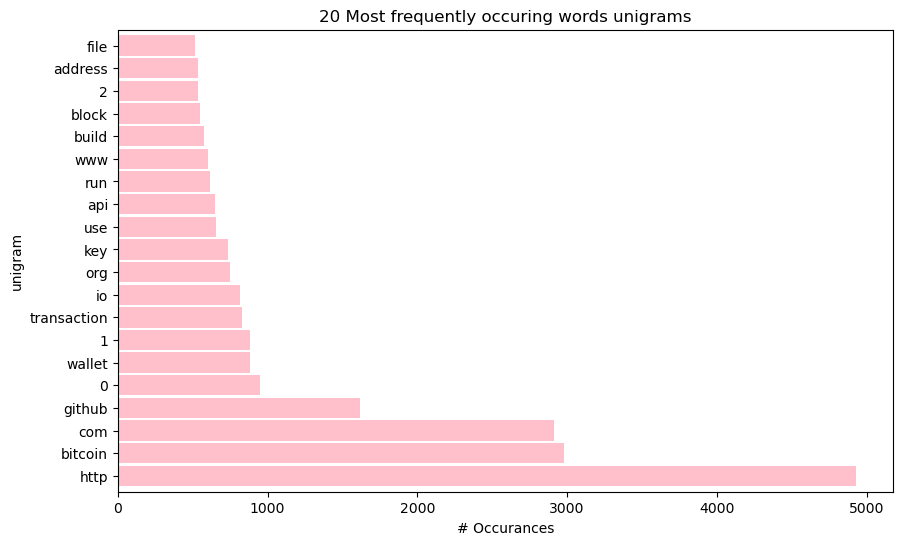

In [15]:
top_20_words_unigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring words unigrams')
plt.ylabel('unigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_words_unigrams.reset_index()['index'].apply(lambda t: t[0])
_ = plt.yticks(ticks, labels)

#### 2. Does the length of the README vary by programming language?

In [16]:
df.shape

(250, 4)

In [17]:
# df['length'] = df['readme_contents'].str.len()

In [18]:
df

,repo,language,readme_contents,clean
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,"[bitcoin, core, integration, staging, tree, ht..."
1,bitcoinbook/bitcoinbook,other,Code Examples: ![travis_ci](https://travis-ci....,"[code, example, travis_ci, http, travis, ci, o..."
2,bitcoinj/bitcoinj,other,image:https://github.com/bitcoinj/bitcoinj/wor...,"[image, http, github, com, bitcoinj, bitcoinj,..."
3,bitcoin/bips,other,"People wishing to submit BIPs, first should pr...","[people, wishing, submit, bips, first, propose..."
4,bitcoinjs/bitcoinjs-lib,other,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...,"[bitcoinjs, bitcoinjs, lib, github, ci, http, ..."
...,...,...,...,...
245,Bitcoin-com/paperwallet.bitcoin.com,other,# Bitcoin.com Paper Wallet\n\nThe Bitcoin.com ...,"[bitcoin, com, paper, wallet, bitcoin, com, pa..."
246,DeFiCh/ain,C++,[![Lint](https://github.com/DeFiCh/ain/actions...,"[lint, http, github, com, defich, action, work..."
247,rustyrussell/bitcoin-iterate,other,This is some fast code to iterate over bitcoin...,"[fast, code, iterate, bitcoind, block, file, e..."
248,gcarq/rusty-blockparser,other,# rusty-blockparser\n\n[![Build Status](https:...,"[rusty, blockparser, build, status, http, trav..."


In [19]:
df.language.value_counts()

other         192
JavaScript     34
C++            24
Name: language, dtype: int64

In [20]:
# df.groupby('language').length.mean().plot.barh()

In [21]:
def plot_length(df):
    df['length'] = df['readme_contents'].str.len()
    df.groupby('language').length.mean().plot.bar()


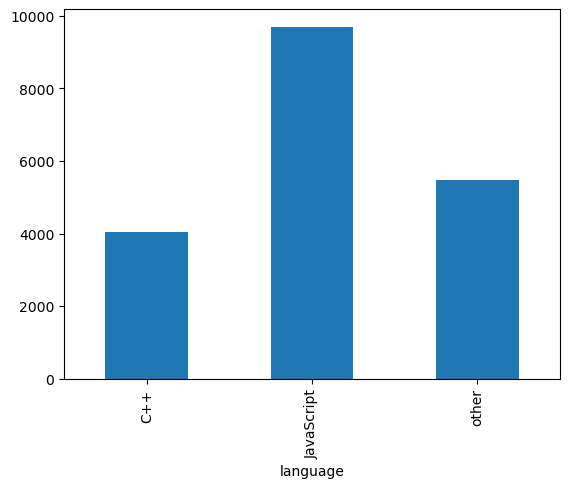

In [22]:
plot_length(df)

#### 3. Do different programming languages use a different number of unique words?

In [23]:
df

,repo,language,readme_contents,clean,length
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,"[bitcoin, core, integration, staging, tree, ht...",3364
1,bitcoinbook/bitcoinbook,other,Code Examples: ![travis_ci](https://travis-ci....,"[code, example, travis_ci, http, travis, ci, o...",6499
2,bitcoinj/bitcoinj,other,image:https://github.com/bitcoinj/bitcoinj/wor...,"[image, http, github, com, bitcoinj, bitcoinj,...",4642
3,bitcoin/bips,other,"People wishing to submit BIPs, first should pr...","[people, wishing, submit, bips, first, propose...",25565
4,bitcoinjs/bitcoinjs-lib,other,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...,"[bitcoinjs, bitcoinjs, lib, github, ci, http, ...",14993
...,...,...,...,...,...
245,Bitcoin-com/paperwallet.bitcoin.com,other,# Bitcoin.com Paper Wallet\n\nThe Bitcoin.com ...,"[bitcoin, com, paper, wallet, bitcoin, com, pa...",1539
246,DeFiCh/ain,C++,[![Lint](https://github.com/DeFiCh/ain/actions...,"[lint, http, github, com, defich, action, work...",2882
247,rustyrussell/bitcoin-iterate,other,This is some fast code to iterate over bitcoin...,"[fast, code, iterate, bitcoind, block, file, e...",1916
248,gcarq/rusty-blockparser,other,# rusty-blockparser\n\n[![Build Status](https:...,"[rusty, blockparser, build, status, http, trav...",10594


In [24]:
lists = []
for i,row in df.iterrows():
    words = df.iloc[i]['clean']
    lists.append(len(set(words)))
df['unique'] = pd.Series(lists)


In [25]:
df

,repo,language,readme_contents,clean,length,unique
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,"[bitcoin, core, integration, staging, tree, ht...",3364,172
1,bitcoinbook/bitcoinbook,other,Code Examples: ![travis_ci](https://travis-ci....,"[code, example, travis_ci, http, travis, ci, o...",6499,247
2,bitcoinj/bitcoinj,other,image:https://github.com/bitcoinj/bitcoinj/wor...,"[image, http, github, com, bitcoinj, bitcoinj,...",4642,199
3,bitcoin/bips,other,"People wishing to submit BIPs, first should pr...","[people, wishing, submit, bips, first, propose...",25565,959
4,bitcoinjs/bitcoinjs-lib,other,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...,"[bitcoinjs, bitcoinjs, lib, github, ci, http, ...",14993,480
...,...,...,...,...,...,...
245,Bitcoin-com/paperwallet.bitcoin.com,other,# Bitcoin.com Paper Wallet\n\nThe Bitcoin.com ...,"[bitcoin, com, paper, wallet, bitcoin, com, pa...",1539,100
246,DeFiCh/ain,C++,[![Lint](https://github.com/DeFiCh/ain/actions...,"[lint, http, github, com, defich, action, work...",2882,149
247,rustyrussell/bitcoin-iterate,other,This is some fast code to iterate over bitcoin...,"[fast, code, iterate, bitcoind, block, file, e...",1916,102
248,gcarq/rusty-blockparser,other,# rusty-blockparser\n\n[![Build Status](https:...,"[rusty, blockparser, build, status, http, trav...",10594,468


In [26]:
df[~(df.language=='other')].sort_values('unique').tail()

,repo,language,readme_contents,clean,length,unique
80,butor/blackbird,C++,[![Build Status](https://travis-ci.org/butor/b...,"[build, status, http, travis, ci, org, butor, ...",16475,603
68,ruimarinho/bitcoin-core,JavaScript,# bitcoin-core\nA modern Bitcoin Core REST and...,"[bitcoin, core, modern, bitcoin, core, rest, r...",19507,612
102,JeanLucPons/VanitySearch,C++,# VanitySearch\n\nVanitySearch is a bitcoin ad...,"[vanitysearch, vanitysearch, bitcoin, address,...",15166,621
85,ccxt/ccxt,JavaScript,# CCXT – CryptoCurrency eXchange Trading Libra...,"[ccxt, cryptocurrency, exchange, trading, libr...",107080,1405
165,MarkFChavez/bitcoin-price-index,JavaScript,This project was bootstrapped with [Create Rea...,"[project, bootstrapped, create, react, app, ht...",108763,1856
